# Imports & Data Load

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# configurations
warnings.filterwarnings("ignore")

In [2]:
# load data
books = pd.read_csv("data/books.csv")
users = pd.read_csv("data/users.csv")
ratings = pd.read_csv("data/ratings.csv")

# Explore data

## Preview data

In [3]:
# preview data
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
# preview data
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
# preview data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Missing Values

In [6]:
# missing values
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

- Nothing major

In [7]:
# missing values
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

- Age has a lot of missing values. Luckily we do not require this feature for our project today!

In [8]:
# missing values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

## Duplicates

In [9]:
# duplicate records
books.duplicated().sum(), users.duplicated().sum(), ratings.duplicated().sum()

(0, 0, 0)

## EDA

### ISBN & Book-Title


In [10]:
print("Total unique ISBNs", books['ISBN'].nunique())
print("Total unique Book names", books['Book-Title'].nunique())

Total unique ISBNs 271360
Total unique Book names 242135


- Many same books have different ISBNs. This could be due to different editions/publications/types of the book.

### Authors

<AxesSubplot:>

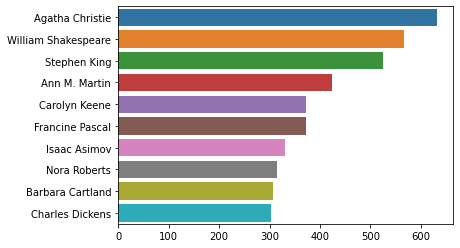

In [11]:
# eda
authors = books['Book-Author'].value_counts()
sns.barplot(authors[:10].values, authors[:10].index)

### Publishers

<AxesSubplot:>

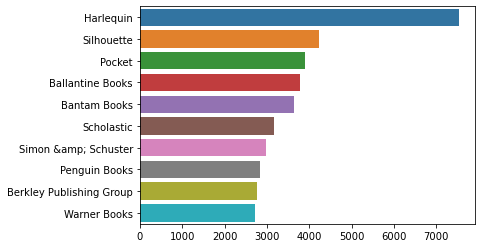

In [12]:
# eda
publishers = books['Publisher'].value_counts()
sns.barplot(publishers[:10].values, publishers[:10].index)

### Ratings

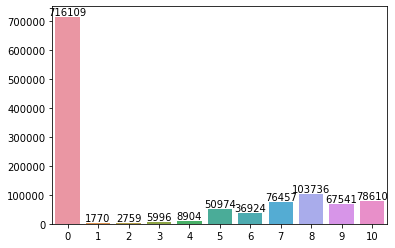

In [13]:
# eda
rating_count = ratings['Book-Rating'].value_counts()
ax = sns.barplot(rating_count.index, rating_count.values)
# ax.bar_label(ax.containers[0])
for i in ax.containers:
    ax.bar_label(i,)

- Most books don't have a rating

### Users

In [14]:
ratings['User-ID'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: User-ID, Length: 105283, dtype: int64

- The dataset has a mix of experienced readers (who have read and rated multiple books) and new readers (who have not rated many books)

# Popularity Based Recommender System

Simply recommend the top 50 books with highest average ratings.

Only those books will be considered which have received a minimum of 250 ratings.

In [15]:
ratings_with_books = ratings.merge(books, on='ISBN')
ratings_with_books.shape

(1031136, 10)

In [16]:
ratings_with_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [17]:
# calculate number of ratings for each book
num_rating_df = ratings_with_books.groupby("Book-Title").count()['Book-Rating'].reset_index()
num_rating_df.rename(columns = {'Book-Rating':'num_ratings'}, inplace=True)
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [18]:
# calculate average rating received by each book
avg_ratings_df = ratings_with_books.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_ratings_df.rename(columns={'Book-Rating':'avg_rating'}, inplace=True)
avg_ratings_df

,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241066,Ã?Â?lpiraten.,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,5.250000
241068,Ã?Â?sterlich leben.,7.000000
241069,Ã?Â?stlich der Berge.,2.666667


In [24]:
# merge ratings and average df
popular_books = num_rating_df.merge(avg_ratings_df, on='Book-Title')
# filter books with num_ratings > 250
popular_books = popular_books[popular_books['num_ratings']>=250].sort_values('avg_rating', ascending=False).head(50).reset_index()
popular_books.drop(['index'], axis=1, inplace=True)
popular_books

,Book-Title,num_ratings,avg_rating
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
1,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
2,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
3,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
4,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453
5,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117
6,The Fellowship of the Ring (The Lord of the Ri...,368,4.948370
7,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.895652
8,"The Two Towers (The Lord of the Rings, Part 2)",260,4.880769
9,To Kill a Mockingbird,510,4.700000


In [27]:
# let's fetch other details about the top 50 books
popular_books = popular_books.merge(books, on='Book-Title').drop_duplicates('Book-Title')

# export data
pickle.dump(popular_books, open('popular.pkl', 'wb'))

- These are the top 50 books with their average ratings

# Collaborative Filtering Recommender System

It depends on both the users and their ratings on the items. Therefore, we will create a table with all the books and the ratings that they have received from each user.

This will enable us to find similarities to recommend the book to each user as per their liking.



|Books|User_1|User_2|...|User_n|
|-|-|-|-|-|
|Book_1|||||
|Book_2|||||
|...|||||
|Book_n|||||

To make the recommender engine more intelligent, we will apply the below filter.

We will select the ratings from users with over 200 ratings and books with more than 50 ratings.

In [33]:
# let's use the dataset with books and their ratings
ratings_with_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1031131,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...
1031132,276688,1575660792,7,Gray Matter,Shirley Kennett,1996,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...
1031133,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...
1031134,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...


In [34]:
# find users and how many ratings they have added
temp = ratings_with_books.groupby('User-ID').count()['Book-Rating'] >= 200
experienced_users = temp[temp].index

In [35]:
# experienced readers
ratings_with_experiened_readers = ratings_with_books[ratings_with_books['User-ID'].isin(experienced_users)]
ratings_with_experiened_readers

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1030883,275970,1880837927,0,The Theology of the Hammer,Millard Fuller,1994,Smyth &amp; Helwys Publishing,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...
1030884,275970,188717897X,0,The Ordeal of Integration: Progress and Resent...,Orlando Patterson,1998,Civitas Book Publisher,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...
1030885,275970,1888889047,0,Pushcart's Complete Rotten Reviews &amp; Rejec...,Bill Henderson,1998,Pushcart Press,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...
1030886,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...


In [36]:
temp = ratings_with_experiened_readers.groupby('Book-Title').count()['Book-Rating'] >= 50
# temp[temp].index

final_ratings_with_books = ratings_with_experiened_readers[ratings_with_experiened_readers['Book-Title'].isin(temp[temp].index)]

In [37]:
final_ratings_with_books.duplicated().sum()

0

- No duplicates

In [38]:
# pivot
final_pivot = final_ratings_with_books.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')
final_pivot.fillna(0, inplace=True)

In [39]:
final_pivot

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- This is exactly what we required

In [40]:
similarity_scores = cosine_similarity(final_pivot)
similarity_scores.shape

(707, 707)

In [41]:
similarity_scores

array([[1.        , 0.0999137 , 0.01189468, ..., 0.11799012, 0.07158663,
        0.04205081],
       [0.0999137 , 1.        , 0.2364573 , ..., 0.07446129, 0.16773875,
        0.14263397],
       [0.01189468, 0.2364573 , 1.        , ..., 0.04558758, 0.04938579,
        0.10796119],
       ...,
       [0.11799012, 0.07446129, 0.04558758, ..., 1.        , 0.07085128,
        0.0196177 ],
       [0.07158663, 0.16773875, 0.04938579, ..., 0.07085128, 1.        ,
        0.10602962],
       [0.04205081, 0.14263397, 0.10796119, ..., 0.0196177 , 0.10602962,
        1.        ]])

- This tells us the similarity score of one item with every other item, based on cosine similarity

In [48]:
# create UDF that will recommend you 5 similar books
def recommend_books(book_name):

    # fetch index for books
    index = np.where(final_pivot.index == book_name)[0][0]

    # fetch similar items
    similar_items = sorted(list(enumerate(similarity_scores[index])), 
                           key=lambda x: x[1],
                           reverse=True)[1:6]
    
    data = []

    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == final_pivot.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [55]:
# export data
pickle.dump(final_pivot, open('final_pivot.pkl', 'wb'))
pickle.dump(books, open('books.pkl', 'wb'))
pickle.dump(similarity_scores, open('similarity_scores.pkl', 'wb'))

In [49]:
recommend_books('You Belong To Me')

[['Loves Music, Loves to Dance',
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0671758896.01.MZZZZZZZ.jpg'],
 ["I'll Be Seeing You",
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0671888587.01.MZZZZZZZ.jpg'],
 ['Before I Say Good-Bye',
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0671004573.01.MZZZZZZZ.jpg'],
 ["Daddy's Little Girl",
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0743206045.01.MZZZZZZZ.jpg'],
 ['All Around the Town',
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0671793489.01.MZZZZZZZ.jpg']]

In [50]:
recommend_books('Zoya')

[['Fine Things',
  'Danielle Steel',
  'http://images.amazon.com/images/P/0440200563.01.MZZZZZZZ.jpg'],
 ['Secrets',
  'DANIELLE STEEL',
  'http://images.amazon.com/images/P/0440176484.01.MZZZZZZZ.jpg'],
 ['Kaleidoscope',
  'June Stepansky',
  'http://images.amazon.com/images/P/0884092097.01.MZZZZZZZ.jpg'],
 ['Exclusive',
  'Sandra Brown',
  'http://images.amazon.com/images/P/0446604232.01.MZZZZZZZ.jpg'],
 ['Five Days in Paris',
  'DANIELLE STEEL',
  'http://images.amazon.com/images/P/0440222842.01.MZZZZZZZ.jpg']]

In [51]:
recommend_books('Message in a Bottle')

[['Nights in Rodanthe',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446531332.01.MZZZZZZZ.jpg'],
 ['The Mulberry Tree',
  'Jude Deveraux',
  'http://images.amazon.com/images/P/0743437640.01.MZZZZZZZ.jpg'],
 ['A Walk to Remember',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446608955.01.MZZZZZZZ.jpg'],
 ["River's End",
  'Nora Roberts',
  'http://images.amazon.com/images/P/0515127833.01.MZZZZZZZ.jpg'],
 ['Nightmares &amp; Dreamscapes',
  'Stephen King',
  'http://images.amazon.com/images/P/0451180232.01.MZZZZZZZ.jpg']]

In [52]:
recommend_books('The Notebook')

[['A Walk to Remember',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446608955.01.MZZZZZZZ.jpg'],
 ['The Rescue',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446610399.01.MZZZZZZZ.jpg'],
 ['One Door Away from Heaven',
  'Dean R. Koontz',
  'http://images.amazon.com/images/P/0553582755.01.MZZZZZZZ.jpg'],
 ['Toxin',
  'Robin Cook',
  'http://images.amazon.com/images/P/0425166619.01.MZZZZZZZ.jpg'],
 ['The Five People You Meet in Heaven',
  'Mitch Albom',
  'http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg']]

In [53]:
recommend_books('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg'],
 ['The Hours : A Novel',
  'Michael Cunningham',
  'http://images.amazon.com/images/P/0312243022.01.MZZZZZZZ.jpg']]

In [54]:
recommend_books('The Da Vinci Code')

[['Angels &amp; Demons',
  'Dan Brown',
  'http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg'],
 ['Touching Evil',
  'Kay Hooper',
  'http://images.amazon.com/images/P/0553583441.01.MZZZZZZZ.jpg'],
 ['Saving Faith',
  'David Baldacci',
  'http://images.amazon.com/images/P/0446608890.01.MZZZZZZZ.jpg'],
 ["The Sweet Potato Queens' Book of Love",
  'JILL CONNER BROWNE',
  'http://images.amazon.com/images/P/0609804138.01.MZZZZZZZ.jpg'],
 ['Middlesex: A Novel',
  'Jeffrey Eugenides',
  'http://images.amazon.com/images/P/0312422156.01.MZZZZZZZ.jpg']]

----